# **Fine-tuning CLIP for Visual Grounding**

*Abstract*

Visual Grounding is a challenging task which aims to locate an object in an image based on a natural language query. Despite impressive advances in computer vision and natural language processing, establishing meaningful connections between distinct elements of images and text to get a good comprehension of context is still a big research area. In our work, we explored some new strategies to solve the problem by laveraging the image-text alignment of Clip as a foundation model for new frameworks specialized in Visual Grounding.

\
*Introduction*

First, we propose a baseline that combines the object detector Yolo [1] and CLIP [2] model without any other component. For each candidate object proposed by Yolo is computed a cosine similarity with the text query and the most similar one is chosen as output prediction. We then tried to break free from the object detector developing a framework based on heatmaps [3] to retrieve the target object and on SAM [4] to draw a proper bounding box. We finally developed a new framework obtained by customizing the CLIP model to compute a low-level probability map from which we find a bounding box through some up-sampling convolutions [5]. Fine-tuning allowed us to exploit Clip strengths without the need for heavy training, therefore beyond the results, it seems to be the most promising direction.

\
*Related work*

- Visual Grounding
- Reffering Image Segmentation
- Adapters and Fine-tuning


<!-- The recent development of new and promising models and methods has lead to a surprising advancement and spread of deep learning frameworks in many areas. Nevertheless, many issues are still far from being fully solved and a lot of researchers are still working on them.\
Visual Grounding is one of this complex task: it consists in retrievial an object in a image based on a text description. To solve the problem, a model has not only to have a deep comprehension of both image and text, but also to be able to relate effectively local and global context.\
Our system try to achieve this aim exploiting the image text allignement already present in Clip and fine-tuning it to adapt to the new objective.

\
In this paper, we propose a transformer based approach for
visual grounding. Unlike existing proposal-and-rank frameworks that rely heavily on pretrained object detectors or
proposal-free frameworks that upgrade an off-the-shelf onestage detector by fusing textual embeddings, our approach
is built on top of a transformer encoder-decoder and is independent of any pretrained detectors or word embedding models. Termed as VGTR – Visual Grounding with TRansformers, our approach is designed to learn semantic-discriminative
visual features under the guidance of the textual description
without harming their location ability. This information flow
enables our VGTR to have a strong capability in capturing
context-level semantics of both vision and language modalities, rendering us to aggregate accurate visual clues implied
by the description to locate the interested object instance. Experiments show that our method outperforms state-of-the-art
proposal-free approaches by a considerable margin on four
benchmarks.

\
Recent advances in computer vision and natural language processing have naturally
led to active research in multi-modal tasks, including Referring Image Segmentation (RIS). Recent approaches have advanced the frontier of RIS by impressive
margins, but they require an additional pretraining stage on external visual grounding datasets to achieve the state-of-the-art performances. We attempt to break free
from this requirement by effectively adapting Contrastive Language-Image Pretraining (CLIP) to RIS. We propose a novel framework that residually adapts frozen
CLIP features to RIS with Fusion Adapters and Backbone Adapters. Freezing CLIP
preserves the backbone’s rich, general image-text alignment knowledge, whilst
Fusion Adapters introduce multi-modal communication and Backbone Adapters
inject new knowledge useful in solving RIS. Our method reaches a new state of the
art on three major RIS benchmarks. We attain such performance without additional
pretraining and thereby absolve the necessity of extra training and data preparation.
Source code and model weights will be available upon publication -->

# Baseline

In this section, we implemented a baseline using Yolo and CLIP.  We process each image sequentially. Initially, Yolo detects all relevant objects within the image. Then, each candidate object is encoded through the CLIP visual encoder while the texx query is processed by the text aìencoder. Finally, we compute the cosine similarity between the encoded representations of each object and the text query. In case of more than one sentence, we compute the average of similarities for each query. We consider as output the object associated with the highest similarity score.


### Things to install

In [ ]:
# download CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# download and unzip RefCOCOg dataset
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz

# download Yolo
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hie1j3rh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hie1j3rh
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=2a50fe4df79997e7c2b04c80596e4eb9705546c4423874bb131532e122f8635d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_t5v5exu/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [02:16<00:00, 98.7MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.5/609.5

### Baseline Dataset

In [ ]:
import json
import clip
import torch
import pandas
import numpy as np

from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Union

from PIL import Image, ImageDraw



class RefcocogDataset(Dataset):
    """  Custom dataset class for RefCOCOg dataset """

    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[0].item()+train_bbox[2].item(), train_bbox[1].item()+train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [ ]:
# General Variables
REFCOCOG_PATH = "refcocog"

if __name__ == "__main__":
    _, preprocess = clip.load("RN50")

    train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocess, tokenization=clip.tokenize)
    val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocess, tokenization=clip.tokenize)
    test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocess, tokenization=clip.tokenize)

    train_dataloader = DataLoader(train_dataset, shuffle=False)
    val_dataloader = DataLoader(val_dataset, shuffle=False)
    test_dataloader = DataLoader(test_dataset, shuffle=False)

100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 238MiB/s]


### Baseline Pipeline

In [ ]:
# Loading of Yolo and CLIP  model
modelYOLO = torch.hub.load('ultralytics/yolov5', 'yolov5x')
device = "cuda" if torch.cuda.is_available() else "cpu"
modelCLIP, preprocessCLIP = clip.load("RN50", device=device)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-24 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 166M/166M [00:09<00:00, 18.1MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def YoloBBoxes(img, modelYOLO):
    """  Applies Yolo model on the image and returns bbox """
    result = modelYOLO(img)
    # result.show()
    bbox = result.pandas().xyxy[0]
    bbox = bbox.reset_index()
    bbox["tconfidence"] = np.nan
    bbox["crop"] = np.nan
    return bbox

def CropImage(image, boxs):
    """ Returns a list of crops of the image  """
    crops = []
    for index, row in boxs.iterrows():
        box = (
            row['xmin'],
            row['ymin'],
            row['xmax'],
            row['ymax'],
        )
        crop = image.crop(box)
        crops.append(crop)
        boxs.at[index, 'crop'] = crop
    return crops

def computeSimilarity(image, sentences, modelCLIP, preprocessCLIP):
    """ compute cosine similarity between a sentence amd an image """
    similarities = []
    for sent in sentences:
        with torch.no_grad():
            image_features = modelCLIP.encode_image(torch.unsqueeze(preprocessCLIP(image).to(device), dim=0)).float().to(device)
            text_features = modelCLIP.encode_text(sent[0].to(device)).float().to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)
    return sum(similarities)/len(similarities)

def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
    """ Compute Intersection area between two bboxes """
    dx = min(fx2, sx2) - max(fx1, sx1)
    dy = min(fy2, sy2) - max(fy1, sy1)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(bboxes, index, label):
    """ compute Itersection of Union between two bboxes """
    intersection = computeIntersection(bboxes['xmin'][index], bboxes['ymin'][index], bboxes['xmax'][index], bboxes['ymax'][index],
                                       label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
    area1 = (bboxes['xmax'][index]-bboxes['xmin'][index])*(bboxes['ymax'][index]-bboxes['ymin'][index])
    area2 = label[2].item()*label[3].item()
    union = area1 + area2 - intersection
    return intersection / union

In [ ]:
def baseline(loader, dataset, modelYOLO, modelCLIP, preprocessCLIP):
    n_samples = 0
    tot_accuracy = 0
    for data_features, data_bbox in loader:

        bboxes = YoloBBoxes(dataset.getImage(data_features), modelYOLO)
        crops = CropImage(dataset.getImage(data_features), bboxes)


        if len(crops) > 0:
            highest_similarity = 0
            index_pred = 0
            for i, crop in enumerate(crops):
                similarity = computeSimilarity(crop, data_features['sentences'], modelCLIP, preprocessCLIP)
                if similarity > highest_similarity:
                    highest_similarity = similarity
                    index_pred = i

            accuracy = computeAccuracy(bboxes, index_pred, data_bbox)
        else:
            accuracy = 0

        if accuracy>=0.5:
          tot_accuracy += 1
        n_samples += 1
        # print(f'Image {n_samples:^8}/{len(dataset):^8}\t{accuracy}\t{accuracy>=0.5}')

        if n_samples%200==0:
          print(f'Total accuracy after {n_samples} samples:\t{tot_accuracy/n_samples}')

    return tot_accuracy/n_samples


### Run the code

In [ ]:
baseline(test_dataloader, test_dataset, modelYOLO, modelCLIP, preprocessCLIP)

Total accuracy after 200 samples:	0.61
Total accuracy after 400 samples:	0.6125
Total accuracy after 600 samples:	0.6083333333333333
Total accuracy after 800 samples:	0.6125
Total accuracy after 1000 samples:	0.615
Total accuracy after 1200 samples:	0.6191666666666666
Total accuracy after 1400 samples:	0.62
Total accuracy after 1600 samples:	0.614375
Total accuracy after 1800 samples:	0.6094444444444445
Total accuracy after 2000 samples:	0.6075
Total accuracy after 2200 samples:	0.605
Total accuracy after 2400 samples:	0.60125
Total accuracy after 2600 samples:	0.6026923076923076
Total accuracy after 2800 samples:	0.5960714285714286
Total accuracy after 3000 samples:	0.594
Total accuracy after 3200 samples:	0.5934375
Total accuracy after 3400 samples:	0.5947058823529412
Total accuracy after 3600 samples:	0.5988888888888889
Total accuracy after 3800 samples:	0.598421052631579
Total accuracy after 4000 samples:	0.59825
Total accuracy after 4200 samples:	0.599047619047619
Total accuracy a

0.5974517220784392

### Observations

This baseline adaptes CLIP for Visual Grounding by simply incorporating the model as part of a longer pipeline highlighting the remarkable zero-shot capabilities of CLIP.
Accuracy evaluation is measured through Intersection over Union (IoU), with a predicted bounding box considered correct when $IoU \ge 0.5$.

Our baseline reached an accuracy of $59.74\%$, which can be considered a good result. This outcome is due to the ability of Yolo to extract a wide range of candidates and of Clip to compute affinity between image and text. However, we found also important limitations that need to be tackled to improve the system:

1. Dependency on the object detector performance\
The system relies heavily on the object detector's performance.
If the object detector does not retrieve an object, there is no possibility to output the correct bbox and this is often the case if we are looking for small objects partially occluded.

2. Lack of Context Comprehension\
In presence of multiple instances of the same object, this baseline is not capable of using the context to infer which is the correct one. This is a major problem because relating text and image components is at the heart of Visual Grounding, therefore it puts in evidence the necessity for further modifications.


We moved on trying to face these two issues. At first, we developed another pipeline in which there is no need for an object detector and subsequently, we focused on the problem of the context which forced us to embark on a new path.

# Baseline without Object Detector

This baseline introduces a different pipeline that eliminates the need for an object detector. We employ the Lavis library to extract a heat map from each image and use it to identify some points with high confidence to belong to the target object. Then, we utilize SAM, Segment Anything Model, SAM, to obtain a mask of the object and the bounding box to return as output.

### Things to import

In [ ]:
# If not already install uncomment the following code

# # CLIP
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# # REFCOCOG
# !gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
# !tar -xf /content/refcocog.tar.gz

# LAVIS
!pip install salesforce-lavis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 25.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import clip
import json
import cv2

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import locale

# from typing import Sequence, Union

locale.getpreferredencoding = lambda: 'UTF-8'

In [ ]:
blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device='cuda'
  )

modelCLIP, preprocessCLIP = clip.load("RN50", device='cuda')

100%|██████████| 3.43G/3.43G [03:04<00:00, 20.0MB/s]


In [ ]:
# SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nzekaray
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nzekaray
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=b2d9b944b1176d6e764ed292da535ee8889e9cc6769d1e4fe5fac702685d7cd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-t70lson2/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-24 09:28:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.88.93, 13.33.88.16, 13.33.88.98, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.88.93|

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


### Functions

In [ ]:
def center_da_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, visualize=False
):

  image_norm = np.float32(image) / 255
  center = [0, 0]

  if average:
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)
    colour_map = gradcam - image_norm

    if visualize==True:
      h, w, c = colour_map.shape

      # PRINT COLOUR MAP
      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('COLOUR MAP')
      ax.imshow(gradcam)
      # ax.imshow(colour_map)
      ax.axis('off')
      fig.tight_layout()

      # PRINT RED CHANNEL
      red_channel = np.zeros((h, w, 1))
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            red_channel[i][j][0] = 1

      fig, ax = plt.subplots(1, 1, figsize=(10, 10))
      plt.title('RED CHANNEL')
      ax.imshow(red_channel)
      ax.axis('off')
      fig.tight_layout()

    # CALCULATE THE BBOX
    xs = []
    ys = []

    for i in range(colour_map.shape[0]):
      for j in range(colour_map.shape[1]):
        if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
          xs.append(i)
          ys.append(j)

    if len(xs)!=0:
      # center[0] = int(np.median(xs))
      # center[1] = int(np.median(ys))
      center[0] = int((max(xs)+min(xs))/2)
      center[1] = int((max(ys)+min(ys))/2)

  return center

In [ ]:
def print_bbox(image, bbox, title = ''):

  image_box = image.copy()
  plt.figure(figsize=(10,10))
  plt.title(title)

  for i in range(bbox[0], bbox[2]):
    for j in range(bbox[1], bbox[3]):
      image_box.putpixel((j, i), (225, 0, 0))

  plt.imshow(image_box)


In [ ]:

def computeIntersection(bbox, BBOX):
  x_min = bbox[0]
  y_min = bbox[1]
  x_max = bbox[2]
  y_max = bbox[3]
  X_MIN = BBOX[0]
  Y_MIN = BBOX[1]
  X_MAX = BBOX[2]
  Y_MAX = BBOX[3]

  dx = min(x_max, X_MAX) - max(x_min, X_MIN)
  dy = min(y_max, Y_MAX) - max(y_min, Y_MIN)
  if (dx>=0) and (dy>=0):
      area = dx*dy
  else:
      area = 0
  return area

def computeAccuracy(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
    area2 = (BBOX[2]-BBOX[0])*(BBOX[3]-BBOX[1])
    union = area1 + area2 - intersection
    return intersection / union

def computePrecision(bbox, BBOX):
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1]) + 0.000001
    return intersection / area1


In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

### Visualization

In [ ]:
modelCLIP.cuda().eval()
device = 'cuda'

def check_baseline(loader, dataset, modelCLIP, preprocessCLIP, n_sample_to_check):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0

  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue


    sentences = dataset.getSentences(data_features)

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      print('TARGET:', target)
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens, average=True, visualize=True)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    for i, (mask, score) in enumerate(zip(masks, scores)):
      plt.figure(figsize=(10,10))
      plt.imshow(image)
      show_mask(mask, plt.gca())
      show_points(input_point, input_label, plt.gca())
      plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
      plt.axis('off')
      plt.show()

    xs = []
    ys = []

    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]
    print_bbox(image, bbox, 'FOUND BBOX')
    print_bbox(image, target_bbox, 'TARGET BBOX')

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    break

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%100==0:
      print('\n-----------------------------------------------------------------')
      print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      print('\n-----------------------------------------------------------------')

  return #tot_accuracy/n_samples


In [ ]:
check_baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP, n_sample_to_check=1)

TARGET: a photo of the man in yellow coat
TARGET: a photo of skiier in red pants


### Baseline with SAM

In [ ]:
modelCLIP.cuda().eval()
device = 'cuda'

def baseline(loader, dataset, modelCLIP, preprocessCLIP):

  n_samples = 0
  tot_accuracy = 0
  tot_precision = 0
  s = 0

  for data_features, data_bbox in loader:

    if n_samples in range(520,530):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(750, 770):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2750, 2760):
      n_samples += 1
      s += 1
      continue

    if n_samples in range(2945, 2950):
      n_samples += 1
      s += 1
      continue

    sentences = dataset.getSentences(data_features)
    # print('num sentences:', len(sentences))

    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    image = dataset.getImage(data_features)

    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []

    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    bbox = [min(xs), min(ys), max(xs), max(ys)]

    # COMPUTE PRECISION
    precision = computePrecision(bbox, target_bbox)
    accuracy = computeAccuracy(bbox, target_bbox)

    n_samples += 1
    tot_accuracy += accuracy
    tot_precision += precision

    # print(f'{n_samples})', 'Precision:', precision, '\tAccuracy:', accuracy, '\n')

    if n_samples%200==0:
      print(f'Total accuracy after {n_samples} samples:\t{tot_accuracy/(n_samples-s)}')
      # print('\n-----------------------------------------------------------------')
      # print('TOT_Precision:', tot_precision/(n_samples-s), 'TOT_Accuracy:', tot_accuracy/(n_samples-s))
      # print('\n-----------------------------------------------------------------')

  return #tot_accuracy/n_samples


### Run the code

In [ ]:
baseline(test_dataloader, test_dataset, modelCLIP, preprocessCLIP)

Total accuracy after 200 samples:	0.4437082553007847
Total accuracy after 400 samples:	0.4440875450768603
Total accuracy after 600 samples:	0.43735782552374664
Total accuracy after 800 samples:	0.44464257584181244
Total accuracy after 1000 samples:	0.45192359849595304


RuntimeError: ignored

### Observations

This baseline proves that is not strictly necessary to use an object detector to perform visual grounding. From the visual encoder, we can retrieve how much each pixel contributes to computing the similarity with the text query. This leads to a heat map which shows which parts of the image are related to the text. The consequent idea is to try to connect each area with the corresponding part of the sentence in order to achieve a deep comprehension of the context. We scratched this idea starting from a simple baseline which tresholds the heatmap in order to consider the most relevant patch. The output bounding box is around the object referred to by this patch. To compute the correct size of the bounding box we used SAM. For each sentence pointing to the same object we extract a point from the heatmap and then we use these points to compute a mask for the object using SAM. The accuracy is computed with IoU and a bounding box is considered correctly classified if $IoU \ge 0.5$, as in the previous baseline.

We managed to achieve  0.44% accuracy, which proves this method can work. Just a little engineering pushed the performance up by 3%, showing there is a wide range for improvements. A big limitation of this baseline is that it doesn't consider the context. We think a specific network that takes as input the whole image concatenated with the heatmap and combines this information with the text query could overcome this issue and achieve good performance. However, we decided to follow another method to relate the image and text. We present it in the last section.

# Fine-tuning CLIP for Visual Grounding

We designed a network subdivided in two stages. The first aims to compute a low-level probability map, the second one to predict a bounding box from this map. We took inspiration from this paper [5] in which a similar approach is followed to perform Referring Image Segmentation. This method allowed us to avoid heavy training and the use of object detector or other segmentation models.


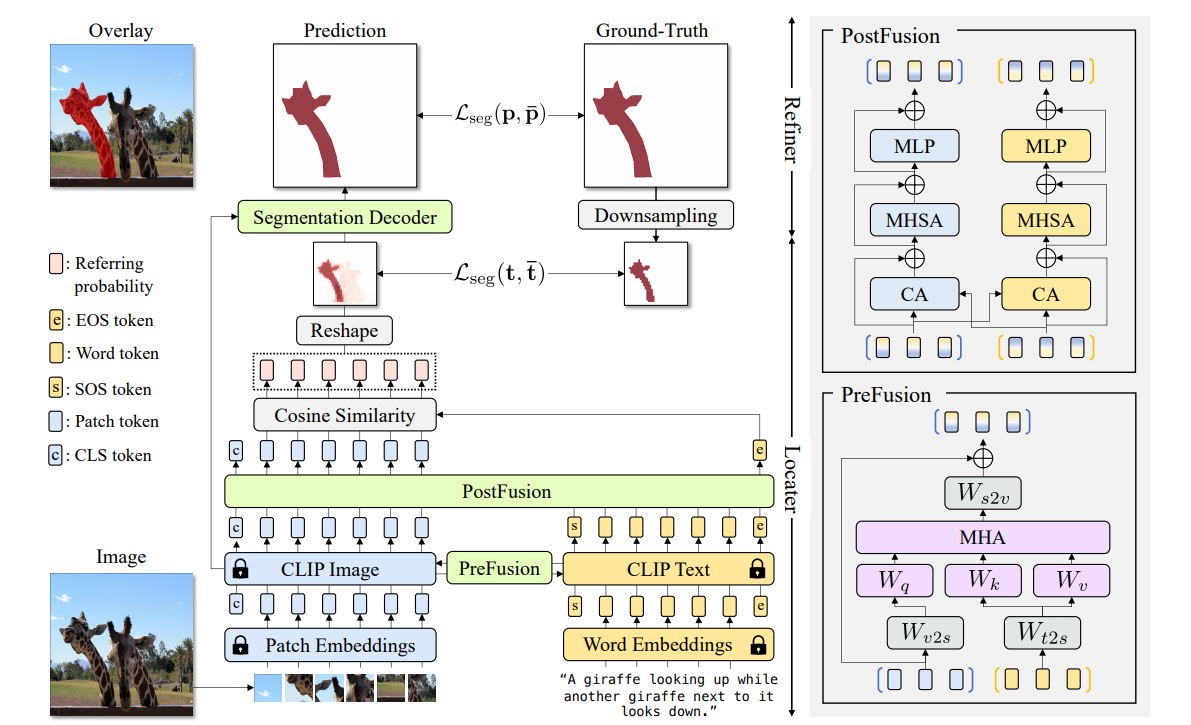

## Dataset and DataLoader

We created a custom dataset class for RefCOCOg dataset. Implemented getters are self-explenatory, we just underline that we also created a method called *computeGroundTruth* to return the mask of the referred object. This is used to compute low_level probability maps necessary as ground_truth for the locator training.

In [ ]:
import json
import pandas
from skimage import io
from torch.utils.data import random_split
from typing import Sequence, Union

from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import numpy as np


class RefcocogDataset(Dataset):
    """ Custom dataset class for RefCOCOg """

    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        # Add Explode to separate list-like sentences column and use them as separate samples
        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area", "segmentation"]], left_on="ann_id", right_on="id") \
            .explode('sentences', ignore_index=True) \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def __computeGroundTruth(self, item):
        image = self.__getimage(item.image_id)
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        draw.polygon(item.segmentation[0], fill="white", width=0)

        return self.__img_preprocess(mask)

    def __img_preprocess(self, image: Image, n_px: int = 224, grid_px: int = 14):
        resized = T.Resize(n_px, interpolation=Image.BICUBIC)(image)
        crop = T.CenterCrop(n_px)(resized)

        grid = T.Resize(grid_px, interpolation=Image.BICUBIC)(crop)

        arr = torch.tensor(np.asarray(grid))
        return arr

    def __get_train_annotations(self):
        return self.annotations[self.annotations.split == "train"].reset_index()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentence):
        return f"a photo of a {sentence['sent']}"

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        # Return {sample, sentence, id}, bbox
        # Return single sentence, probably preprocess needed so we do not waste data

        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, {'bbox': item.bbox, 'gt': self.__computeGroundTruth(item)}


if __name__ == "__main__":
    _, preprocess = clip.load("ViT-B/32")

    dataset = RefcocogDataset("../Dataset/refcocog", split="train", tokenization=clip.tokenize, transform=preprocess)
    train, val = random_split(dataset, [0.8, 0.2])
    train_dataloader = DataLoader(train)

    train_features, train_bbox = next(iter(train_dataloader))
    dataset.getImage(train_features).show()
    print(dataset.getSentences(train_features))
    print(len(train))
    print(len(val))

a photo of a an ambulance
64410
16102


## Define the Clip Model

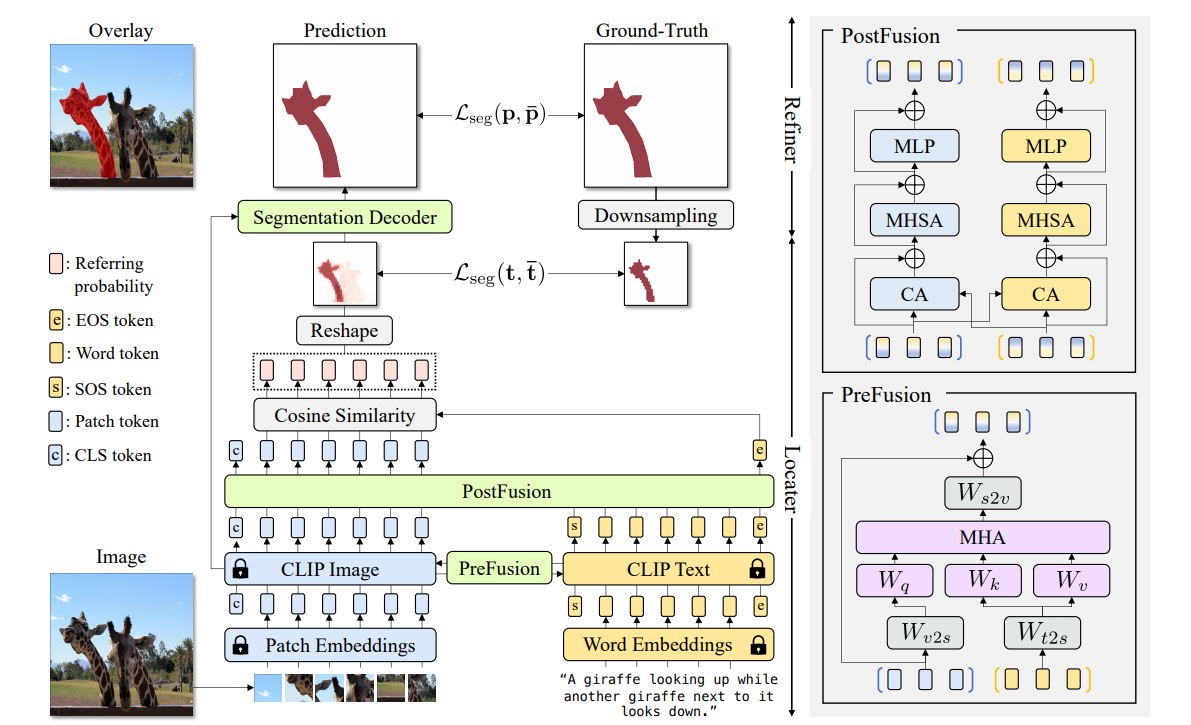

* ***Locator***
* ***Refiner***


### Modified Clip

In [ ]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from .adapters import BackboneAdapter, PreFusionAdapter, PostFusionAdapter

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None, n_layer: int = 0, layers: int = 0, type_input: str = None):
        super().__init__()

        self.n_layer = n_layer
        self.type_input = type_input

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor, back_adap_MHSA, back_adap_MLP):
        # print(f'layer: {self.n_layer} type input: {self.type_input} input shape: {x.shape}')
        x = x + self.attention(self.ln_1(x))
        x = x + back_adap_MHSA(x)
        x = x + self.mlp(self.ln_2(x))
        x = x + back_adap_MLP(x)
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None, type_input: str = None):
        super().__init__()
        self.type_input = type_input
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask, n_layer=n_layer, layers=layers, type_input=type_input) for n_layer in range(layers)])

    def forward(self, x: torch.Tensor):
        # print(f'type input: {self.type_input}\tinput shape: {x.shape}')
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads, type_input='image')

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.vision_layers = vision_layers
        self.transformer_layers = transformer_layers

        self.vision_width = vision_width
        self.transformer_width = transformer_width

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer( # transformer for text
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask(),
            type_input='text'
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def init_adapters(self):
        vis_hidden_dim = int(self.vision_width / 2) # hidden dimension chosen as half of input embedding
        txt_hidden_dim = int(self.transformer_width / 2) # hidden dimension chosen as half of input embedding
        self.backbone_adapters_MHSA_vis = nn.Sequential(*[BackboneAdapter(self.vision_width, vis_hidden_dim) for _ in range(self.vision_layers)]).to(self.dtype)
        self.backbone_adapters_MLP_vis = nn.Sequential(*[BackboneAdapter(self.vision_width, vis_hidden_dim) for _ in range(self.vision_layers)]).to(self.dtype)
        self.backbone_adapters_MHSA_txt = nn.Sequential(*[BackboneAdapter(self.transformer_width, txt_hidden_dim) for _ in range(self.transformer_layers)]).to(self.dtype)
        self.backbone_adapters_MLP_txt = nn.Sequential(*[BackboneAdapter(self.transformer_width, txt_hidden_dim) for _ in range(self.transformer_layers)]).to(self.dtype)

        self.prefusion_adapters = nn.Sequential(*[PreFusionAdapter(self.vision_width, self.transformer_width, 512, 8) for _ in range(self.vision_layers-6)]).to(self.dtype)
        self.postfusion_adapter = nn.Sequential(*[PostFusionAdapter(shared_dim=self.visual.proj.shape[1], CA_n_head=8, MHSA_n_head=8, MLP_hidden_dim=256) for _ in range(6)]).to(self.dtype)

    def freeze_for_training(self):
        for param in self.parameters():
            param.requires_grad = False
        for param in self.postfusion_adapter.parameters():
            param.requires_grad = True
        for param in self.prefusion_adapters.parameters():
            param.requires_grad = True
        for param in self.backbone_adapters_MHSA_vis.parameters():
            param.requires_grad = True
        for param in self.backbone_adapters_MHSA_txt.parameters():
            param.requires_grad = True
        for param in self.backbone_adapters_MLP_vis.parameters():
            param.requires_grad = True
        for param in self.backbone_adapters_MLP_txt.parameters():
            param.requires_grad = True

    def load_parameters(self, path):
        state_dict = torch.load(path)
        try:
            self.load_state_dict(state_dict)
        except RuntimeError:
            print(f"Failed to load state dict. N keys found: {len(state_dict.keys())}. N keys model: {len(self.state_dict().keys())}")

    def save_state_dict(self, path):
        torch.save(self.state_dict(), path)

    def encode(self, image, text):
        assert(isinstance(self.visual, VisionTransformer))
        assert(self.vision_layers == self.transformer.layers)
        assert(self.visual.proj.shape[1] ==  self.text_projection.shape[1])

        x_image = image.type(self.dtype)
        x_image = self.visual.conv1(x_image)
        x_image = x_image.reshape(x_image.shape[0], x_image.shape[1], -1)
        x_image = x_image.permute(0, 2, 1)
        x_image = torch.cat([self.visual.class_embedding.to(x_image.dtype) + torch.zeros(x_image.shape[0], 1, x_image.shape[-1], dtype=x_image.dtype, device=x_image.device), x_image], dim=1)
        x_image = x_image + self.visual.positional_embedding.to(x_image.dtype)
        x_image = self.visual.ln_pre(x_image)
        x_image = x_image.permute(1, 0, 2)

        x_text = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]
        x_text = x_text + self.positional_embedding.type(self.dtype)
        x_text = x_text.permute(1, 0, 2)


        for i in range(self.vision_layers):
            if i > 5:
                v, t = self.prefusion_adapters[i-6](x_image, x_text)
                x_image = x_image + v
                x_text = x_text + t
                x_image = self.visual.transformer.resblocks[i](x_image, self.backbone_adapters_MHSA_vis[i], self.backbone_adapters_MLP_vis[i])
                x_text = self.transformer.resblocks[i](x_text, self.backbone_adapters_MHSA_txt[i], self.backbone_adapters_MLP_txt[i])
            else:
                x_image = self.visual.transformer.resblocks[i](x_image, self.backbone_adapters_MHSA_vis[i], self.backbone_adapters_MLP_vis[i])
                x_text = self.transformer.resblocks[i](x_text, self.backbone_adapters_MHSA_txt[i], self.backbone_adapters_MLP_txt[i])



        x_image = x_image.permute(1, 0, 2) # batch, CLS+patches, features
        x_text = x_text.permute(1, 0, 2) # batch, seq, features

        patch_tokens = x_image

        x_image = self.visual.ln_post(x_image[:, 0, :]) # take CLS token and layer norm
        x_text = self.ln_final(x_text).type(self.dtype) # layer norm


        if self.visual.proj is not None:
            x_image = x_image @ self.visual.proj # final proj into shared space

        # text tokens projected in shared space
        text_tokens = x_text[torch.arange(x_text.shape[0])] @ self.text_projection

        # for each batch, take the last token (EOT) and project it into the shared space
        x_text = x_text[torch.arange(x_text.shape[0]), text.argmax(dim=-1)] @ self.text_projection


        # layer norm and projection into shared space for patch tokens
        for token in range(patch_tokens.shape[1]):
            patch_tokens[:, token] = self.visual.ln_post(patch_tokens[:, token, :])
        if self.visual.proj is not None:
            patch_tokens = patch_tokens @ self.visual.proj


        patch_tokens = patch_tokens.permute(1, 0, 2)
        text_tokens = text_tokens.permute(1, 0, 2)
        for i in range(len(self.postfusion_adapter)):
            v, t = self.postfusion_adapter[i](patch_tokens, text_tokens)
            patch_tokens = v + patch_tokens
            text_tokens = t + text_tokens

        return (patch_tokens.permute(1, 0, 2)[:, 0, :], # CLS token of each sample in batch
                text_tokens.permute(1, 0, 2)[torch.arange(text_tokens.shape[1]), text.argmax(dim=-1)], # EOT token of each sentence
                patch_tokens.permute(1, 0, 2), # patch tokens
                text_tokens.permute(1, 0, 2)) # text tokens

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()

### Adapters

In [ ]:
import torch.nn as nn

# 768 -> hidden per visual
# 512 -> hidden per text
class BackboneAdapter(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.down_proj = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.up_proj = nn.Linear(hidden_dim, input_dim)

        # initialize down proj with Kaiming Normal, up proj with zeros
        nn.init.kaiming_normal_(self.down_proj.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.up_proj.weight)
        self.up_proj.bias.data.fill_(0.0) # not specified in paper, maybe remove

    def forward(self, x):
        x = self.down_proj(x)
        x = self.relu(x)
        x = self.up_proj(x)
        return x



class PreFusionAdapter(nn.Module):
    def __init__(self, image_input_dim, text_input_dim, shared_dim, n_head):
        super().__init__()
        self.ln_image = nn.LayerNorm(image_input_dim)
        self.ln_text = nn.LayerNorm(text_input_dim)
        self.W_v2s = nn.Linear(image_input_dim, shared_dim)
        self.W_t2s = nn.Linear(text_input_dim, shared_dim)
        self.ln_image2 = nn.LayerNorm(shared_dim)
        self.ln_text2 = nn.LayerNorm(shared_dim)
        self.CA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=n_head)
        self.CA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=n_head)
        self.W_s2v = nn.Linear(shared_dim, image_input_dim)
        self.W_s2t = nn.Linear(shared_dim, text_input_dim)

        # initialize projections with zeros
        nn.init.zeros_(self.W_v2s.weight)
        nn.init.zeros_(self.W_t2s.weight)
        nn.init.zeros_(self.W_s2v.weight)
        nn.init.zeros_(self.W_s2t.weight)
        self.W_v2s.bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.W_t2s.bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.W_s2v.bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.W_s2t.bias.data.fill_(0.0) # not specified in paper, maybe remove

    def forward(self, image, text):
        image = self.ln_image(image)
        text = self.ln_text(text)
        image = self.W_v2s(image)
        text = self.W_t2s(text)
        image = self.ln_image2(image)
        text = self.ln_text2(text)
        # in CA_image the query is the image, the key and value are the text
        image, _ = self.CA_image(query=image, key=text, value=text, need_weights=False)
        text, _ = self.CA_text(query=text, key=image, value=image, need_weights=False)
        image = self.W_s2v(image)
        text = self.W_s2t(text)
        return image, text



class PostFusionAdapter(nn.Module):
    def __init__(self, shared_dim, CA_n_head, MHSA_n_head, MLP_hidden_dim):
        super().__init__()
        # cross attention without the projections at the start
        # then MHSA and MLP for each modality

        self.ln_image = nn.LayerNorm(shared_dim)
        self.ln_text = nn.LayerNorm(shared_dim)
        self.CA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=CA_n_head)
        self.CA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=CA_n_head)
        self.ln_image2 = nn.LayerNorm(shared_dim)
        self.ln_text2 = nn.LayerNorm(shared_dim)
        self.MHSA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=MHSA_n_head)
        self.MHSA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=MHSA_n_head)
        self.ln_image3 = nn.LayerNorm(shared_dim)
        self.ln_text3 = nn.LayerNorm(shared_dim)
        self.MLP_image = nn.Sequential(
            nn.Linear(shared_dim, MLP_hidden_dim),
            nn.ReLU(),
            nn.Linear(MLP_hidden_dim, shared_dim)
        )
        self.MLP_text = nn.Sequential(
            nn.Linear(shared_dim, MLP_hidden_dim),
            nn.ReLU(),
            nn.Linear(MLP_hidden_dim, shared_dim)
        )

        # initialize MLPs with zeros, also value projections in CA and MHA with zeros
        nn.init.zeros_(self.MLP_image[0].weight)
        nn.init.zeros_(self.MLP_image[2].weight)
        nn.init.zeros_(self.MLP_text[0].weight)
        nn.init.zeros_(self.MLP_text[2].weight)
        nn.init.zeros_(self.CA_image.in_proj_weight[-512:]) # last 512 in first dimension are weights for value projection
        nn.init.zeros_(self.CA_text.in_proj_weight[-512:])
        nn.init.zeros_(self.MHSA_image.in_proj_weight[-512:])
        nn.init.zeros_(self.MHSA_text.in_proj_weight[-512:])

        self.MLP_image[0].bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.MLP_image[2].bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.MLP_text[0].bias.data.fill_(0.0) # not specified in paper, maybe remove
        self.MLP_text[2].bias.data.fill_(0.0) # not specified in paper, maybe remove
        nn.init.zeros_(self.CA_image.in_proj_bias[-512:]) # last 512 are biases for value projection
        nn.init.zeros_(self.CA_text.in_proj_bias[-512:])
        nn.init.zeros_(self.MHSA_image.in_proj_bias[-512:])
        nn.init.zeros_(self.MHSA_text.in_proj_bias[-512:])

    def forward(self, image, text):
        image = self.ln_image(image)
        text = self.ln_text(text)
        image, _ = self.CA_image(query=image, key=text, value=text, need_weights=False)
        text, _ = self.CA_text(query=text, key=image, value=image, need_weights=False)
        image = self.ln_image2(image)
        text = self.ln_text2(text)
        image, _ = self.MHSA_image(query=image, key=image, value=image, need_weights=False)
        text, _ = self.MHSA_text(query=text, key=text, value=text, need_weights=False)
        image = self.ln_image3(image)
        text = self.ln_text3(text)
        image = self.MLP_image(image)
        text = self.MLP_text(text)
        return image, text

## Loss Functions

## Optimizer & Training Loop

## All Toghether

## Experiments and discussion

## Comparison with other ours hipotesis and State-of-the-arts

## Ohter ideas / Proposals for futher improvements

## Conclusion

# References

1. "You Only Look Once: Unified, Real-Time Object Detection"
Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi
[2016]

2. "Learning transferable visual models from natural language supervision."
Radford, Alec, et al.
[2021]

3. "BLIP: Bootstrapping Language-Image Pre-training for
Unified Vision-Language Understanding and Generation"
Junnan Li Dongxu Li Caiming Xiong Steven Hoi
Salesforce Research
[2022]

4. "Segment Anything"
Kirillov, Mintun, Ravi et al.
Meta AI Research, FAIR
[2023]

5. "RISCLIP: Referring Image Segmentation Framework using CLIP"
Seoyeon Kim, Minguk Kang, Jaesik Park
[2023]

6. "Attention Is All You Need"
